Ide: tag dansk-sproget wikipedia, find alle brugere og lav netværk over brugere, der har redigeret de samme artikler. Derefter, få lix-tal eller lignende fra alle artikler, og se om der er sammenhæng... Eller groupér efter konnektivitet, og se på sammenhængen i grupperne baseret på keywords i artiklerne, eller fordelingen af kategorier.

X Filter navne med bot eller ip-adresser.
X Få data
X Konstruer graf
X Cluster
O Test clusters for modularity mod random graphs
O Test text similarity mellem og indenfor clusters
O Find kategorier for clusters

# Analyzing the Network of Bots on the Danish Wikipedia

## 1. Motivation

For many years now Wikipedia has been one of the most important sources of information on the internet, with millions of articles in all the world's major languages. Relying solely on the collaboration of strangers, Wikipedia has gone from being a radical experiment in free information to a trustworthy source of knowledge. As the project has grown over the years, automation has been vital in keeping articles up to date, making otherwise tedious edits, and empowering contributors to make the most use of what they have to contribute. In this project we take a look at the bots that maintain and expand the Danish Wikipedia, how they work together, and see how network analysis and textual analysis can shed light on their contributions to the wiki.

In [107]:
import copy
import pandas as pd
from itertools import chain
from nltk import word_tokenize
from itertools import combinations
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pywikibot
import networkx as nx
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from netwulf import visualize
import community as community_louvain
import os

In [108]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Basic stats

All the data in this project has been collected by ourselves, using the library 'pywikibot' which provides an easy way to connect to the Wikimedia API. By iterating through all the pages in the Danish Wikipedia, we were able to collect a dataset of roughly 260,000 pages (estimated 85% of all Danish pages), along with all the bots having contributed to those pages, and the categories the pages belong to. All bots on Wikipedia are registered, and by cross-checking the list of bots on the Danish Wikipedia with the contributors to a given page, we could be certain not to get any 'real' users in our dataset.

In addition to the page data, we have also gathered information on all the bots, how many pages they have edited, and the total amount of edits they have performed. In all, we collected data on 197 bots (83% of all the bots). Most of the bots not included in this dataset had no contributions to any pages as of yet, and were therefore deemed not to be of much interest.

In [9]:
pages_dataframe = pd.read_pickle('data/pages_dataframe_final')

In [10]:
bots_dataframe = pd.DataFrame(pages_dataframe['bots'].explode().value_counts())
bots_dataframe = bots_dataframe.rename_axis('name')
bots_dataframe = bots_dataframe.reset_index()
pd.to_pickle(bots_dataframe, 'bots_dataframe')
bots_dataframe

,name,count
0,Steenthbot,209306
1,MGA73bot,96866
2,Luckas-bot,54237
3,EmausBot,52480
4,Xqbot,49228
...,...,...
192,SreeBot,2
193,TAP Bot 1,2
194,Kolega2357-Bot,1
195,Dpkbot,1


In [11]:
def get_bot_data(bot_name):
    site = pywikibot.Site('da', 'wikipedia')
    bot = pywikibot.User(site, bot_name)
    edit_count = bot.editCount()
    return {'edit_count': edit_count}

bots_dataframe = pd.concat([bots_dataframe, bots_dataframe['name'].apply(lambda x: pd.Series(get_bot_data(x)))], axis=1)
bots_dataframe

,name,count,edit_count
0,Steenthbot,209306,751959
1,MGA73bot,96866,274384
2,Luckas-bot,54237,194041
3,EmausBot,52480,181033
4,Xqbot,49228,137064
...,...,...,...
192,SreeBot,2,4
193,TAP Bot 1,2,12
194,Kolega2357-Bot,1,9
195,Dpkbot,1,3


### Graph construction

From the page data we can construct a graph with the contributing bots constituting the nodes, with links between them if they have contributed to the same page. Each edge will also contain the amount of pages the two bots both have contributed to.

In [81]:
edge_dict = defaultdict(lambda: {'pages':[],'n_pages':0})
only_contributor = defaultdict(lambda: 0)
pbar = tqdm(total=pages_dataframe.shape[0])
def page_edges(page):
    pbar.update(1)
    contributors = page['bots']
    if len(contributors) < 2:
        if len(contributors) == 1:
            only_contributor[contributors[0]] += 1
        return []
    contributors.sort()
    contributor_pairs = list(combinations(contributors, r=2))
    for contributor_pair in contributor_pairs:
        edge_dict[contributor_pair]['pages'].append(page['name'])
        edge_dict[contributor_pair]['n_pages'] += 1

pages_dataframe.apply(page_edges, axis=1)
G = nx.Graph()
G.add_edges_from(edge_dict.keys())
nx.set_edge_attributes(G, edge_dict)

100%|█████████▉| 262178/262278 [00:46<00:00, 5718.91it/s] 

In the construction of the graph, we took note of those pages where only one bot have contributed to, and now we can add the number of pages contributed to solely by a certain bot to our bot data:

In [82]:
only_contributor = pd.DataFrame(list(only_contributor.items()), columns=['name', 'only contributor count'])
bots_dataframe = pd.merge(bots_dataframe, only_contributor, on='name', how='outer').fillna({'only contributor count':0})
bots_dataframe

,name,count,edit_count,top 5 tokens,only contributor count
0,Steenthbot,209306,751959,"[:, ændre, erstatter, eksisterende, data]",70945.0
1,MGA73bot,96866,274384,"[xx, sprog, flytter, link, iabot]",3872.0
2,Luckas-bot,54237,194041,"[:, zh, oc, ko, kategori]",66.0
3,EmausBot,52480,181033,"[:, retter, dobbelt, omdirigering, team]",1697.0
4,Xqbot,49228,137064,"[retter, omdirigering, dobbelt, :, diskussion]",8096.0
...,...,...,...,...,...
192,SreeBot,2,4,"[:, qu, ay, bs, eo]",0.0
193,TAP Bot 1,2,12,"[:, velkommen, bbc, knowledge, ms]",0.0
194,Kolega2357-Bot,1,9,"[:, kolega-bot, kategori, mpikambana, mg]",0.0
195,Dpkbot,1,3,"[:, ml, ケイ酸ナトリウム, സർലഫ, സലകകററ]",0.0


In [9]:
attribute_dict = bots_dataframe.set_index('name').T.to_dict('dict')
nx.set_node_attributes(G, attribute_dict)

### Graph analysis

We can now take a look at the resulting graph.

In [106]:
n_nodes = len(G.nodes)
n_edges = len(G.edges)
mean_degree = np.mean(list(dict(G.degree).values()))
n_components = nx.number_connected_components(G)
print(f'Number of nodes in graph: {n_nodes}')
print(f'Number of edges in graph: {n_edges} out of {n_nodes*(n_nodes-1)/2} possible')
print(f'Mean degree <k> in graph: {mean_degree}')
print(f'Number of connected components in graph: {n_components}')

Number of nodes in graph: 197
Number of edges in graph: 15024 out of 19306.0 possible
Mean degree <k> in graph: 152.5279187817259
Number of connected components in graph: 1


From the basic stats, we see that the network is extremely connected, since approximately 75% of the possible existing links actually are there. We see that the average degree, 152, is not that far off from the number of nodes, suggesting that many of the bots have contributed to a page with almost all other bots at some point in time. The mean degree is way past log(N), and the graph is therefore far beyond supercritical - hypercritical might be a better term.

In [ ]:
visualize(G)

In [11]:
p = 2*n_edges/(n_nodes*(n_nodes-1))
G_random = nx.gnp_random_graph(n_nodes, p)

We now take a look at the degree distribution, as contrasted with a random graph

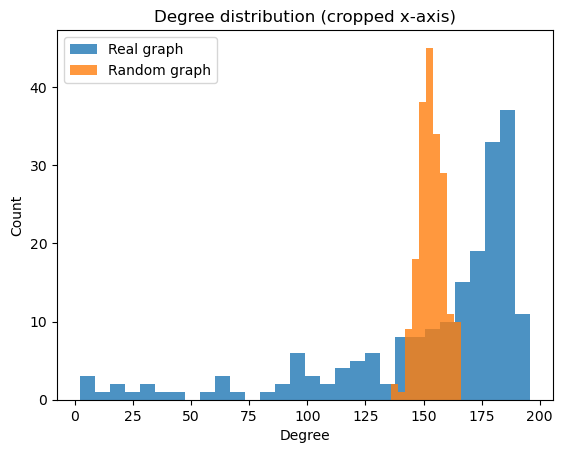

In [16]:
g_deg_random = dict(G_random.degree).values()
g_deg = dict(G.degree).values()
plt.hist(g_deg, alpha=0.8,bins=30, label='Real graph')
plt.hist(g_deg_random, alpha=0.8, label='Random graph')
plt.title('Degree distribution')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.legend()
plt.show()

We see that, like many other graphs in the real world the degree distribution is far more heavy-tailed than for the random graph. Interestingly, there are many more heavily connected nodes than sparsely connected ones. 

In [61]:
g_deg_assort = nx.degree_assortativity_coefficient(G)
g_count_assort = nx.attribute_assortativity_coefficient(G, 'count')
g_edit_count_assort = nx.attribute_assortativity_coefficient(G, 'edit_count')
g_only_contrib_assort = nx.attribute_assortativity_coefficient(G, 'only contributor count')

print(f'Assortativity by degree: {g_deg_assort}')
print(f'Assortativity by page count: {g_count_assort}')
print(f'Assortativity by edit count: {g_edit_count_assort}')
print(f'Assortativity by only contributor pages: {g_only_contrib_assort}')

Assortativity by degree: -0.23707266331244956
Assortativity by page count: -0.005738042216992627
Assortativity by edit count: -0.0055661349891391
Assortativity by only contributor pages: -0.023442735883572745


In [62]:
# Get closeness centrality using nx built in function.
c_centrality = nx.closeness_centrality(G)
c_centrality_sorted = dict(sorted(c_centrality.items(), key=lambda item: item[1]))
top5_c = list(c_centrality_sorted.items())[:-6:-1]

for name, centrality in top5_c:
    print(f'Name: {name}, centrality: {centrality}')

Name: Steenthbot, centrality: 1.0
Name: Thijs!bot, centrality: 0.9849246231155779
Name: EmausBot, centrality: 0.9849246231155779
Name: Xqbot, centrality: 0.98
Name: MGA73bot, centrality: 0.98


In [63]:
# get eigenvector centrality using nx built-in function.
e_centrality = nx.eigenvector_centrality(G)
e_centrality_sorted = dict(sorted(e_centrality.items(), key=lambda item: item[1]))
top5_e = list(e_centrality_sorted.items())[:-6:-1]

for name, centrality in top5_e:
    print(f'Name: {name}, centrality: {centrality}')

Name: Steenthbot, centrality: 0.08179464836881363
Name: Thijs!bot, centrality: 0.0817647570314459
Name: Xqbot, centrality: 0.0817205802070015
Name: MGA73bot, centrality: 0.0817205802070015
Name: Luckas-bot, centrality: 0.08171179473957559


### Clustering

In [83]:
partition = community_louvain.best_partition(G)
n_communities = max(partition.values()) + 1
n_communities

In [88]:
bots_dataframe['community'] = bots_dataframe['name'].apply(lambda name: partition[name])
bots_dataframe

,name,count,edit_count,top 5 tokens,only contributor count,community
0,Steenthbot,209306,751959,"[:, ændre, erstatter, eksisterende, data]",70945.0,0
1,MGA73bot,96866,274384,"[xx, sprog, flytter, link, iabot]",3872.0,0
2,Luckas-bot,54237,194041,"[:, zh, oc, ko, kategori]",66.0,0
3,EmausBot,52480,181033,"[:, retter, dobbelt, omdirigering, team]",1697.0,0
4,Xqbot,49228,137064,"[retter, omdirigering, dobbelt, :, diskussion]",8096.0,0
...,...,...,...,...,...,...
192,SreeBot,2,4,"[:, qu, ay, bs, eo]",0.0,0
193,TAP Bot 1,2,12,"[:, velkommen, bbc, knowledge, ms]",0.0,0
194,Kolega2357-Bot,1,9,"[:, kolega-bot, kategori, mpikambana, mg]",0.0,0
195,Dpkbot,1,3,"[:, ml, ケイ酸ナトリウム, സർലഫ, സലകകററ]",0.0,0


In [13]:
def communities_of_page(bots):
    communities = []
    for bot in bots:
        try:
            communities.append(partition[bot])
        except KeyError:
            pass
    return list(set(communities))

pages_dataframe['communities'] = pages_dataframe['bots'].apply(communities_of_page)
pages_dataframe

,name,bots,categories,communities
0,Flagstaff,"[ArthurBot, BenzolBot, Bot-Schafter, Broadbot,...","[Byer i Arizona, Commons-kategori på Wikidata ...","[0, 1]"
1,Flak,"[Broadbot, EmausBot, Hxhbot]","[Flertydig, Flertydig (samlet)]","[0, 1]"
2,Flak (sandgrund),[MGA73bot],[Omdirigeringer forbundet til et Wikidata-emne],[1]
3,Flakfortet,"[Luckas-bot, MGA73bot, PenguinBot, Steenthbot,...","[Koordinater på Wikidata, Københavns Befæstnin...",[1]
4,Flakhaven,[Steenthbot],"[Artikler med døde links, Koordinater på Wikid...",[1]
...,...,...,...,...
262273,Flagguirlande,[],"[Julepynt, Traditioner]",[]
262274,Flagofficer,"[Luckas-bot, MGA73bot, Steenthbot]","[Kilder mangler (samlet liste), Kilder mangler...",[1]
262275,Flags of the World,"[EmausBot, Luckas-bot, MGA73bot, PalnaBot, Ste...","[Community Sites, Læringsnetsteder, Vexillologi]","[0, 1]"
262276,Flagskib,"[Amirobot, Ken123BOT, Luckas-bot, PenguinBot, ...","[Påbegyndte artikler (samlet liste), Påbegyndt...","[0, 1]"


In [ ]:
stop_words = set(stopwords.words('danish'))
def tokenize_category_list(category_list, exclude_stop=True):
    text = ' '.join(category_list)
    text = text.lower()
    text = ''.join([char for char in text if (char.isalpha() or char in ' -')])
    tokens = word_tokenize(text)
    if exclude_stop:
        return [token for token in tokens if not token in stop_words]
    return tokens

In [64]:
pages_dataframe['tokens'] = pages_dataframe['categories'].apply(tokenize_category_list)
pages_dataframe

,name,bots,categories,communities,tokens
0,!!!,"[Addbot, LucienBOT, Luckas-bot, MGA73bot, Stee...","[Artikler med musikhenvisninger fra Wikidata, ...","[0, 2]","[artikler, musikhenvisninger, wikidata, common..."
1,"""Fjerne Israel fra landkortet""- kontroversen",[Xqbot],[],[0],[]
2,"""Fjerne Israel fra landkortet""-bemærkningen","[Broadbot, Xqbot]",[],[0],[]
3,"""Gråt"" rumvæsen",[Xqbot],[],[0],[]
4,"""Heroes""","[Dipsacus fullonum bot, InternetArchiveBot, MG...","[Album fra 1977, David Bowie-album, Påbegyndte...",[0],"[album, david, bowie-album, påbegyndte, artikl..."
...,...,...,...,...,...
780,1. division i ishockey 1975-76,[InternetArchiveBot],"[DM i ishockey, Ishockey i 1975, Ishockey i 19...",[0],"[dm, ishockey, ishockey, ishockey, sider, weba..."
781,1. division i ishockey 1976-77,[InternetArchiveBot],"[DM i ishockey, Ishockey i 1976, Ishockey i 19...",[0],"[dm, ishockey, ishockey, ishockey, sider, weba..."
782,1. division i ishockey 1977-78,[InternetArchiveBot],"[DM i ishockey, Ishockey i 1977, Ishockey i 19...",[0],"[dm, ishockey, ishockey, ishockey, sider, weba..."
783,1. division i ishockey 1978-79,[InternetArchiveBot],"[DM i ishockey, Ishockey i 1978, Ishockey i 19...",[0],"[dm, ishockey, ishockey, ishockey, sider, weba..."


In [73]:
corpus = pages_dataframe[['communities','tokens']].explode('communities').groupby('communities')['tokens'].apply(lambda x: list(chain(*x)))
corpus

communities
0    [artikler, musikhenvisninger, wikidata, common...
1    [intet, lokalt, billede, intet, billede, wikid...
2    [artikler, musikhenvisninger, wikidata, common...
3    [intet, lokalt, billede, intet, billede, wikid...
Name: tokens, dtype: object

In [89]:
# Returns top k terms as defined by TF-IDF
def top_k_terms_TF_IDF(tokens, k, IDF_dict):
    tokens, counts = np.unique(tokens, return_counts=True)
    tfidf = np.zeros(len(counts))
    for i, (token, count) in enumerate(list(zip(tokens, counts))):
        tfidf[i] = count * IDF_dict[token]
    top_k_idxs = np.argsort(tfidf)[:-(k+1):-1]
    return tokens[top_k_idxs]

# Returns top k most frequent terms.
def top_k_terms_TF(tokens, k):
    unique_tokens, counts = np.unique(tokens, return_counts=True)
    top_k_idxs = np.argsort(counts)[:-(k+1):-1]
    return np.array(unique_tokens)[top_k_idxs]

# For the whole corpus define the IDF value for each term and return
# the results as a dictionary: {term:IDF}
def IDF(corpus):
    IDF_dict = defaultdict(lambda: 0)
    N = len(corpus)
    for doc in corpus:
        for term in list(set(doc)):
            IDF_dict[term] += 1
    return {term: np.log(N / count) for term, count in IDF_dict.items()}

In [ ]:
IDF_dict = IDF(corpus)
TFIDF_df = pd.DataFrame(data={c: top_k_terms_TF_IDF(corpus[c], 10, IDF_dict) for c in range(4)})
TFIDF_df

### Textual analysis
categories
edits
first line of articles
find a few interesting bots

In [94]:
stop_words = set(stopwords.words('danish')) | set(stopwords.words('english'))
stop_words = stop_words | {'robot','r','tilføjer','ændrer','fjerner'}
def tokenize_contributions(contributions, exclude_stop=True):
    text = ' '.join(contributions)
    text = text.lower()
    text = ''.join([char for char in text if (char.isalpha() or char in ' -')])
    tokens = word_tokenize(text)
    if exclude_stop:
        return [token for token in tokens if not token in stop_words]
    return tokens

In [95]:
pbar = tqdm(total=bots_dataframe.shape[0])
def top_k_tokens(bot_name, k=10):
    pbar.update(1)
    site = pywikibot.Site('da', 'wikipedia')
    bot = pywikibot.User(site, bot_name)
    contributions = list(bot.contributions())
    contributions_text = [c[-1] for c in contributions]
    tokens = tokenize_contributions(contributions_text)
    return top_k_terms_TF(tokens, k)

bots_dataframe['top 10 tokens'] = bots_dataframe['name'].apply(top_k_tokens)


100%|██████████| 197/197 [01:58<00:00,  1.67it/s]

100%|██████████| 197/197 [01:34<00:00,  6.18it/s]

In [98]:
corpus = bots_dataframe.groupby('community')['top 10 tokens'].apply(lambda x: list(chain(*x)))
corpus

community
0    [ændre, opdatering, data, erstatter, nyeste, t...
1    [ved, kategori, enwpawbawb, brug, eksterne, he...
Name: top 10 tokens, dtype: object

In [101]:
IDF_dict = IDF(corpus)
TF_df = pd.DataFrame(data={c: top_k_terms_TF(corpus[c], 10) for c in range(2)})
TF_df

,0,1
0,fr,ru
1,es,es
2,ru,fr
3,pl,pl
4,sv,pt
5,ja,ja
6,pt,fi
7,nl,nl
8,fi,sv
9,-,di


## 3. Tools, theory and analysis. Describe the process of theory to insight
Talk about how you’ve worked with text, including regular expressions, unicode, etc.
Describe which network science tools and data analysis strategies you’ve used, how those network science measures work, and why the tools you’ve chosen are right for the problem you’re solving.
How did you use the tools to understand your dataset?

The network analysis has provided us with insights into the way the bots collaborate, and how they behave. By looking at the degree distribution...

The textual analysis posed an interesting problem in this project. Most of what the bots are doing have less to do with writing articles, and more to do with maintaining and updating the metadata and structure of the articles. Luckily, the edits they perform come with more or less descriptive messages, which we have used to get a sense of the purpose of each bot. 



## 4. Discussion. Think critically about your creation
What went well?
What is still missing? What could be improved? Why?